In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings
import pickle

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
import networkx as nx

### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair

### function - compare the body track result from different camera pairs

In [3]:
from ana_functions.compare_bodytracking_allcamerapairs import compare_bodytracking_allcamerapairs
from ana_functions.bodytracking_singlecameras import bodytracking_singlecameras

### function - align the two cameras

In [4]:
from ana_functions.camera_align import camera_align

### function - merge the two pairs of cameras

In [5]:
from ana_functions.camera_merge import camera_merge

### function - make demo videos for the body part tracking

In [6]:
from ana_functions.tracking_video_demo import tracking_video_demo

### function - find social gaze time point

In [7]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint

### function - define time point of behavioral events

In [8]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint

### function - plot behavioral events

In [9]:
from ana_functions.plot_bhv_events import plot_bhv_events

### function - plot inter-pull interval

In [10]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - interval between all behavioral events

In [11]:
from ana_functions.bhv_events_interval import bhv_events_interval

## Analyze each session

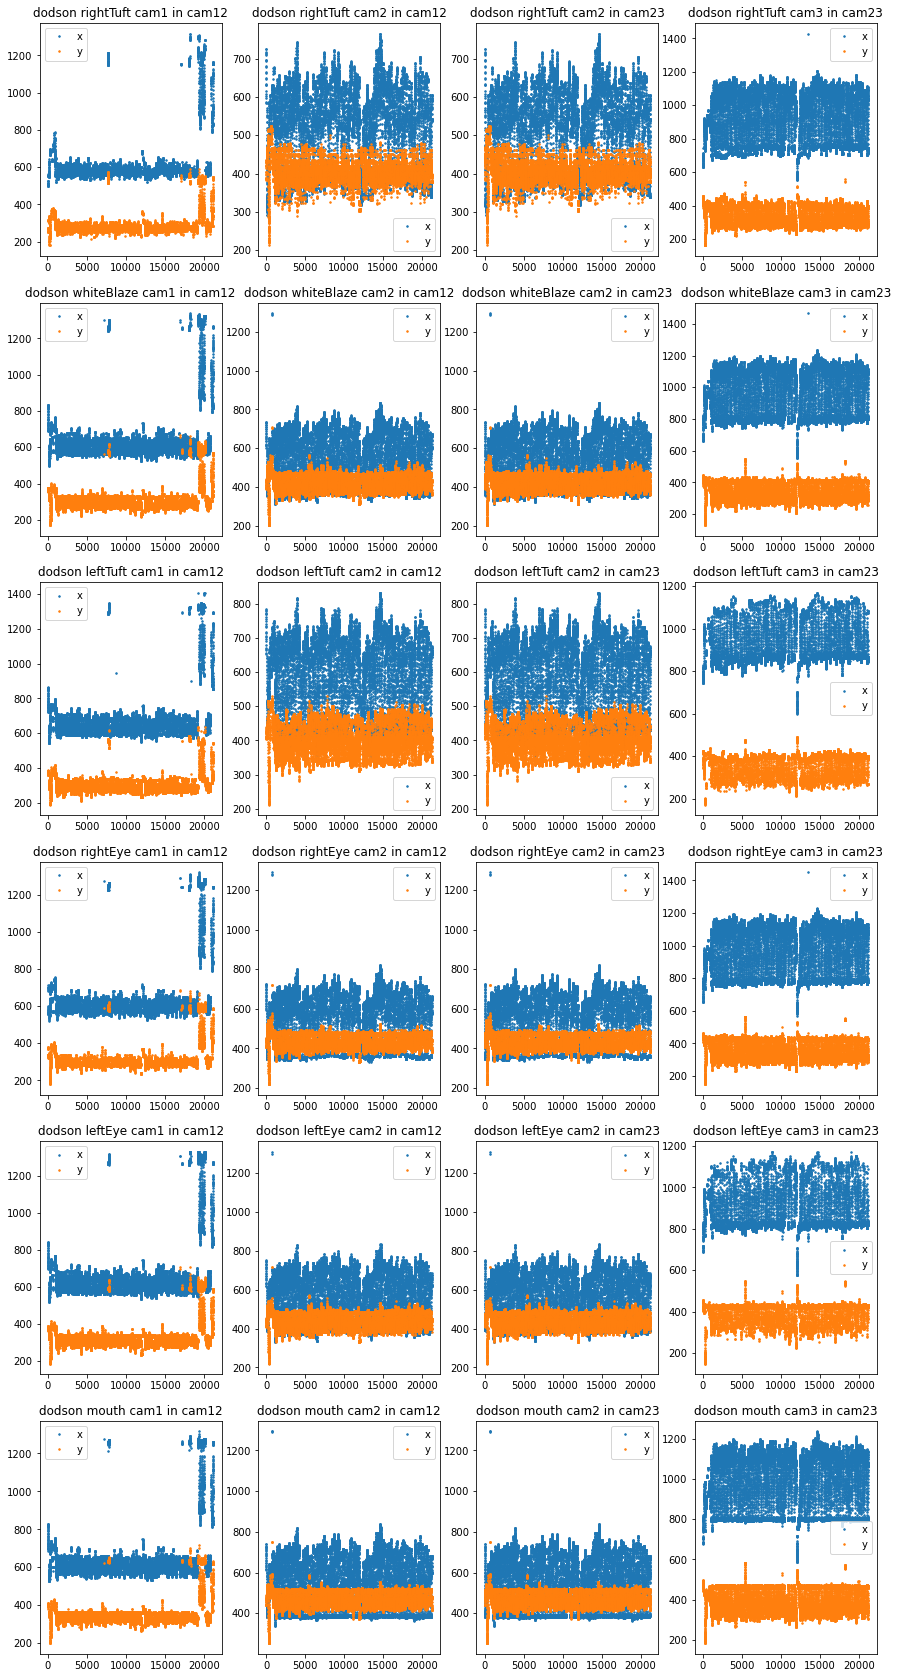

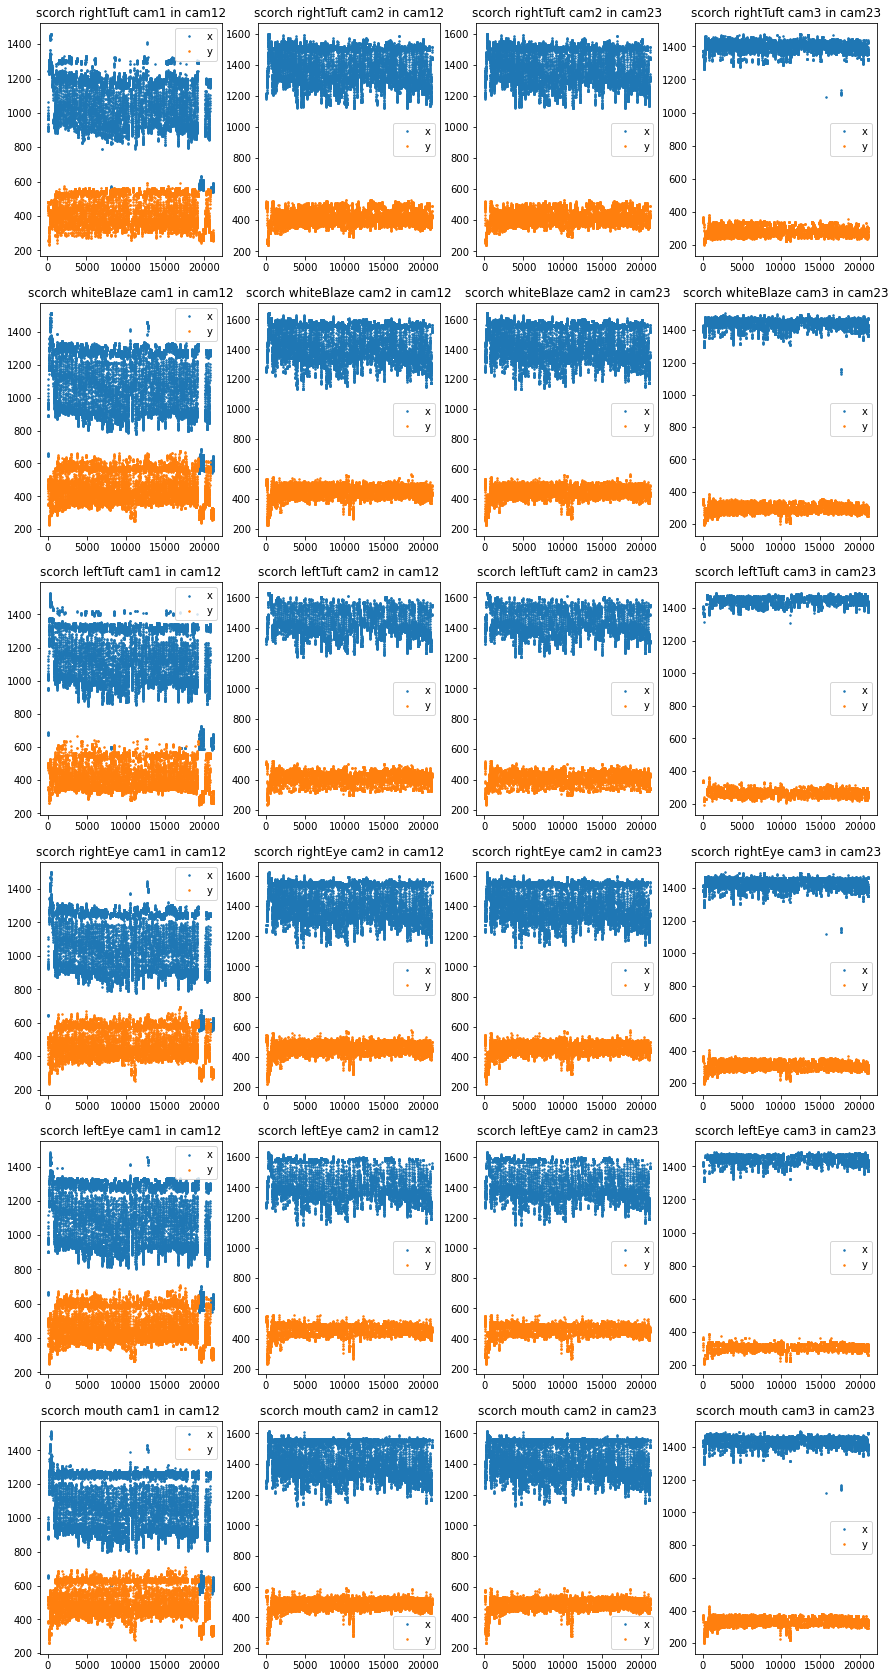

In [12]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
# angle_thres = np.pi/18 # 10 degree
angle_thres = np.pi/4 # 45 degree
angle_thres_name = '45'

merge_campairs = ['_average'] # "": merge the two pairs (at the level of frames); 
                              # "_pair12(23)": use camera pair 1 and 2 (2 and 3) 
                              # "_averarge": average results from pair 12 and 23 after the final analysis
        
# get the fps of the analyzed video
fps = 30

# re-analyze the video or not
reanalyze_video = 0

# all the videos (no misaligned ones)
# dodson scorch
if 0:
    dates_list = [
                  "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                  "20221011","20221013","20221014","20221015","20221017",
                  "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                  "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",

                  "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                  "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220","20221221",
                  "20230208","20230209","20230213","20230214","20230111","20230112","20230201",
                  "20230215"            
                 ]
# eddie sparkle
if 1:
    dates_list = [
                  # "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                  # "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                  # "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                  # "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                  # "20230321","20230322","20230324","20230327","20230328",
                  # "20230330","20230331","20230403","20230404","20230405","20230406",
                  "20230407"
               ]
# ginger kanga
if 0:
    dates_list = [
                  "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                  "20230303","20230307","20230314","20230315","20230316","20230317"         
               ]
#
# dates_list = ["20230317"]

ndates = np.shape(dates_list)[0]

# eddie sparkle
if 1:
    animal1_fixedorder = 'eddie'
    animal2_fixedorder = 'sparkle'

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    animal1_fixedorder = 'ginger'
    animal2_fixedorder = 'kanga'

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

    
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# all the videos (no misaligned ones)
# dodson scorch 
if 0:
    session_start_times = [ 
                             6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                             2.80, 27.80, 272.50, 27.90, 27.00,
                            28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                            15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 

                            75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                             0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  0.00,
                             0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                            33.00
                          ] # in second
# eddie sparkle
if 1:
    session_start_times = [ 
                             # 8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                             # 4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                             # 7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                             # 8.00,8.00,4.00,123.00,14.00,8.80,
                             # 7.00,7.50,5.50,11.00,9.00,
                             # 17.00,4.50,9.30,25.50,20.40,21.30,
                             24.80
                          ] # in second  
# ginger kanga
if 0:
    session_start_times = [ 
                             0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                            34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                          ] # in second  
#  
# session_start_times = [30.50] # in second


session_start_frames = session_start_times * fps # fps is 30Hz

DAGs_all_dates = np.zeros((ndates,4,4))
DAGs_thres_dates = np.zeros((ndates,4,4))
ntempres_dates = np.zeros((ndates,1,1))
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))


for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    session_start_time = session_start_times[idate]
    
    # folder path
    camera12_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
    camera23_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
    
    merge_campair = merge_campairs[0]
    
    # load camera tracking results
    try:
        # dummy
        if reanalyze_video:
            print("re-analyze the data")
            dummy
        ## read
        with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'rb') as f:
            body_part_locs_camera23 = pickle.load(f) 
        with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'rb') as f:
            body_part_locs_camera12 = pickle.load(f) 
    except:
        print("did not save data - body part tracking")
        # analyze and save
        camera12_h5_file = camera12_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_weikang.h5"
        camera12_h5_data = pd.read_hdf(camera12_h5_file)
        body_part_locs_camera12 = body_part_locs_eachpair(camera12_h5_data)
        with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'wb') as f:
            pickle.dump(body_part_locs_camera12, f)
        #
        camera23_h5_file = camera23_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_weikang.h5"
        camera23_h5_data = pd.read_hdf(camera23_h5_file)
        body_part_locs_camera23 = body_part_locs_eachpair(camera23_h5_data)
        with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'wb') as f:
            pickle.dump(body_part_locs_camera23, f)
    
    # load behavioral results
    try:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
        trial_record_json = bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_1.json"
        bhv_data_json = bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_1.json"
        session_info_json = bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_1.json"
        #
        trial_record = pd.read_json(trial_record_json)
        bhv_data = pd.read_json(bhv_data_json)
        session_info = pd.read_json(session_info_json)
    except:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
        trial_record_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_1.json"
        bhv_data_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_1.json"
        session_info_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_1.json"
        #
        trial_record = pd.read_json(trial_record_json)
        bhv_data = pd.read_json(bhv_data_json)
        session_info = pd.read_json(session_info_json)
    
    # get animal info
    animal1 = session_info['lever1_animal'][0].lower()
    animal2 = session_info['lever2_animal'][0].lower()
    
    # get task type and cooperation threshold
    try:
        coop_thres = session_info["pulltime_thres"][0]
        tasktype = session_info["task_type"][0]
    except:
        coop_thres = 0
        tasktype = 1
    tasktypes_all_dates[idate] = tasktype
    coopthres_all_dates[idate] = coop_thres   
    
    # clean up the trial_record
    warnings.filterwarnings('ignore')
    trial_record_clean = pd.DataFrame(columns=trial_record.columns)
    for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
        trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
    trial_record_clean = trial_record_clean.reset_index(drop = True)
    
    # change bhv_data time to the absolute time
    time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
    for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        ind = bhv_data["trial_number"]==itrial+1
        new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
        time_points_new["time_points_new"][ind] = new_time_itrial
    bhv_data["time_points"] = time_points_new["time_points_new"]
    bhv_data = bhv_data[bhv_data["time_points"] != 0]

    
    # analyze behavior results
    # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
    succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
    
    trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
    #
    pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
    pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
    pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
    pulltime_diff = pulltime[1:] - pulltime[0:-1]
    interpull_intv = pulltime_diff[pullid_diff==1]
    interpull_intv = interpull_intv[interpull_intv<10]
    mean_interpull_intv = np.nanmean(interpull_intv)
    std_interpull_intv = np.nanstd(interpull_intv)
    #
    interpullintv_all_dates[idate] = mean_interpull_intv
    
    pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
    pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
    
    
    # compare the body tracking results from the camera pairs
    # compare_bodytracking_allcamerapairs(body_part_locs_camera12,body_part_locs_camera23,animal1_fixedorder,animal2_fixedorder,date_tgt,saveornot=1)
    
    # look at single camera results
    bodyparts_cam1_cam12 = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera-1DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000_el.h5"
    bodyparts_cam2_cam12 = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera-2DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000_el.h5"
    bodyparts_cam2_cam23 = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera-2DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000_el.h5"
    bodyparts_cam3_cam23 = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera-3DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000_el.h5"
    #
    bodytracking_singlecameras(body_part_locs_camera12,body_part_locs_camera23,bodyparts_cam1_cam12,bodyparts_cam2_cam12,bodyparts_cam2_cam23,bodyparts_cam3_cam23,animal1_fixedorder,animal2_fixedorder,date_tgt,saveornot=1)
    
    # demo videos
    # nframes = 30*10
    # tracking_video_demo(body_part_locs_camera12,date_tgt,"camera12",nframes)
    # tracking_video_demo(body_part_locs_camera23,date_tgt,"camera23",nframes)

### plot the transition probability from social gaze to pull

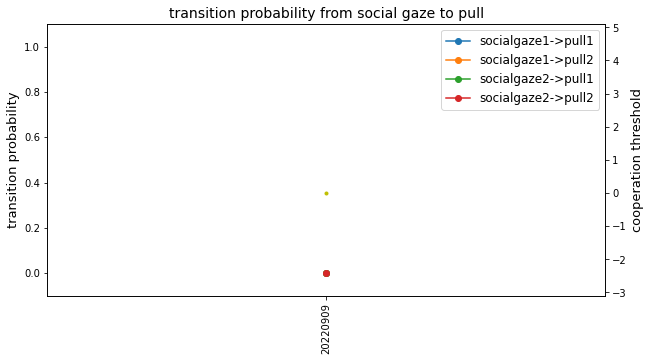

In [133]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,2,0],'o-',label = "socialgaze1->pull1")
ax1.plot(DAGs_all_dates[:,2,1],'o-',label = "socialgaze1->pull2")
ax1.plot(DAGs_all_dates[:,3,0],'o-',label = "socialgaze2->pull1")
ax1.plot(DAGs_all_dates[:,3,1],'o-',label = "socialgaze2->pull2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to pull", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-3.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()

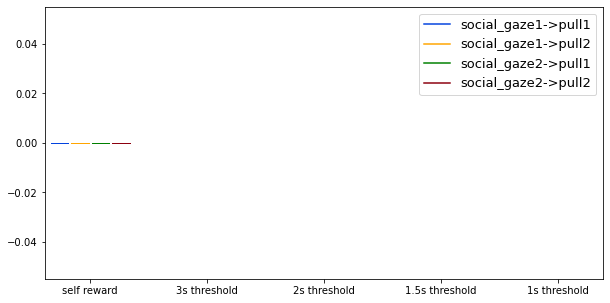

In [134]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze1_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],2,0]]
gaze1_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],2,1]]
gaze2_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],3,0]]
gaze2_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],3,1]]
gaze1_pull1_plot = plt.boxplot(gaze1_pull1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
gaze1_pull2_plot = plt.boxplot(gaze1_pull2,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
gaze2_pull1_plot = plt.boxplot(gaze2_pull1,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
gaze2_pull2_plot = plt.boxplot(gaze2_pull2,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_pull1_plot, '#0343DF', 'social_gaze1->pull1')
define_box_properties(gaze1_pull2_plot, '#FFA500', 'social_gaze1->pull2')
define_box_properties(gaze2_pull1_plot, '#008000', 'social_gaze2->pull1')
define_box_properties(gaze2_pull2_plot, '#8C000F', 'social_gaze2->pull2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to social gaze

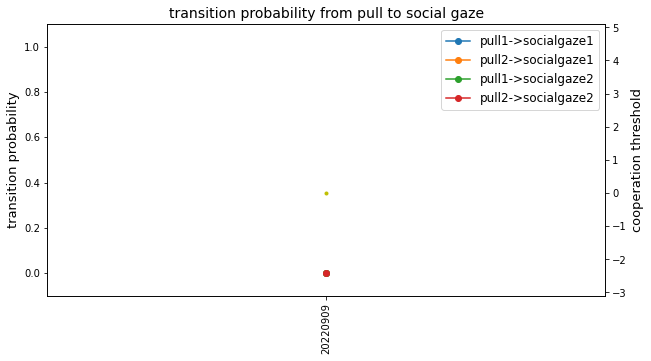

In [135]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,0,2],'o-',label = "pull1->socialgaze1")
ax1.plot(DAGs_all_dates[:,1,2],'o-',label = "pull2->socialgaze1")
ax1.plot(DAGs_all_dates[:,0,3],'o-',label = "pull1->socialgaze2")
ax1.plot(DAGs_all_dates[:,1,3],'o-',label = "pull2->socialgaze2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to social gaze", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-3.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()

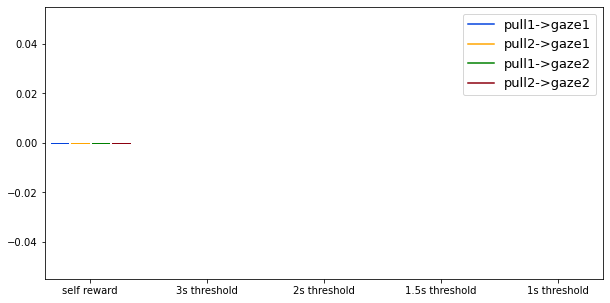

In [136]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

pull1_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,2]]
pull2_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,2]]
pull1_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,3]]
pull2_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,3]]
pull1_gaze1_plot = plt.boxplot(pull1_gaze1,positions=np.array(np.arange(len(pull1_gaze1)))*4.0-1.05,widths=0.6)
pull2_gaze1_plot = plt.boxplot(pull2_gaze1,positions=np.array(np.arange(len(pull2_gaze1)))*4.0-0.35,widths=0.6)
pull1_gaze2_plot = plt.boxplot(pull1_gaze2,positions=np.array(np.arange(len(pull1_gaze2)))*4.0+0.35,widths=0.6)
pull2_gaze2_plot = plt.boxplot(pull2_gaze2,positions=np.array(np.arange(len(pull2_gaze2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_gaze1_plot, '#0343DF', 'pull1->gaze1')
define_box_properties(pull2_gaze1_plot, '#FFA500', 'pull2->gaze1')
define_box_properties(pull1_gaze2_plot, '#008000', 'pull1->gaze2')
define_box_properties(pull2_gaze2_plot, '#8C000F', 'pull2->gaze2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

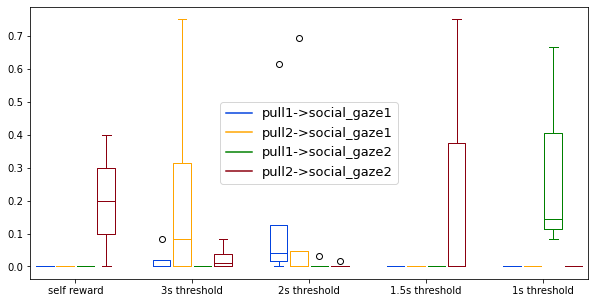

In [41]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

pull1_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,2]]
pull2_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,2]]
pull1_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,3]]
pull2_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,3]]
pull1_gaze1_plot = plt.boxplot(pull1_gaze1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
pull2_gaze1_plot = plt.boxplot(pull2_gaze1,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
pull1_gaze2_plot = plt.boxplot(pull1_gaze2,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
pull2_gaze2_plot = plt.boxplot(pull2_gaze2,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_gaze1_plot, '#0343DF', 'pull1->social_gaze1')
define_box_properties(pull2_gaze1_plot, '#FFA500', 'pull2->social_gaze1')
define_box_properties(pull1_gaze2_plot, '#008000', 'pull1->social_gaze2')
define_box_properties(pull2_gaze2_plot, '#8C000F', 'pull2->social_gaze2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to pull

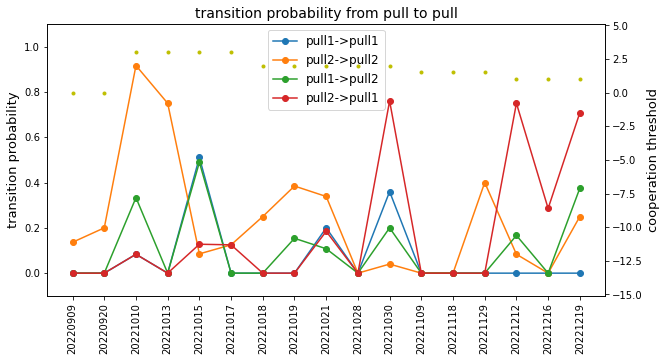

In [42]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,0,0],'o-',label = "pull1->pull1")
ax1.plot(DAGs_all_dates[:,1,1],'o-',label = "pull2->pull2")
ax1.plot(DAGs_all_dates[:,0,1],'o-',label = "pull1->pull2")
ax1.plot(DAGs_all_dates[:,1,0],'o-',label = "pull2->pull1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to pull", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-15.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()

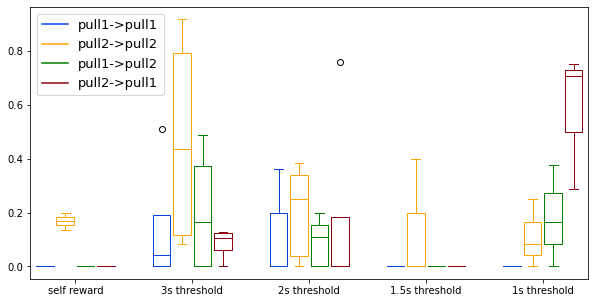

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

pull1_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,0]]
pull2_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,1]]
pull1_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,1]]
pull2_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,0]]
pull1_pull1_plot = plt.boxplot(pull1_pull1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
pull2_pull2_plot = plt.boxplot(pull2_pull2,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
pull1_pull2_plot = plt.boxplot(pull1_pull2,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
pull2_pull1_plot = plt.boxplot(pull2_pull1,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_pull1_plot, '#0343DF', 'pull1->pull1')
define_box_properties(pull2_pull2_plot, '#FFA500', 'pull2->pull2')
define_box_properties(pull1_pull2_plot, '#008000', 'pull1->pull2')
define_box_properties(pull2_pull1_plot, '#8C000F', 'pull2->pull1')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from social gaze to social gaze

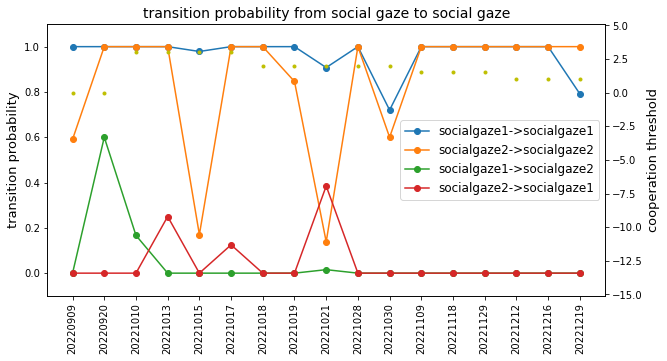

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,2,2],'o-',label = "socialgaze1->socialgaze1")
ax1.plot(DAGs_all_dates[:,3,3],'o-',label = "socialgaze2->socialgaze2")
ax1.plot(DAGs_all_dates[:,2,3],'o-',label = "socialgaze1->socialgaze2")
ax1.plot(DAGs_all_dates[:,3,2],'o-',label = "socialgaze2->socialgaze1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to social gaze", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-15.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()

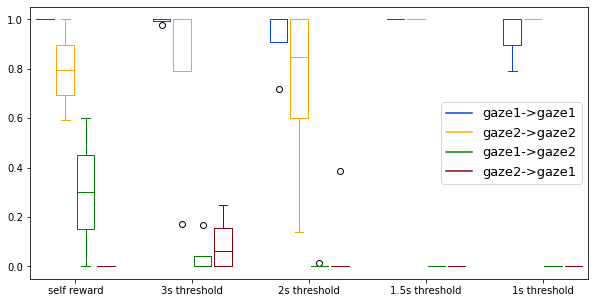

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze1_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],2,2]]
gaze2_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],3,3]]
gaze1_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],2,3]]
gaze2_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],3,2]]
gaze1_gaze1_plot = plt.boxplot(gaze1_gaze1,positions=np.array(np.arange(len(gaze1_gaze1)))*4.0-1.05,widths=0.6)
gaze2_gaze2_plot = plt.boxplot(gaze2_gaze2,positions=np.array(np.arange(len(gaze2_gaze2)))*4.0-0.35,widths=0.6)
gaze1_gaze2_plot = plt.boxplot(gaze1_gaze2,positions=np.array(np.arange(len(gaze1_gaze2)))*4.0+0.35,widths=0.6)
gaze2_gaze1_plot = plt.boxplot(gaze2_gaze1,positions=np.array(np.arange(len(gaze2_gaze1)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_gaze1_plot, '#0343DF', 'gaze1->gaze1')
define_box_properties(gaze2_gaze2_plot, '#FFA500', 'gaze2->gaze2')
define_box_properties(gaze1_gaze2_plot, '#008000', 'gaze1->gaze2')
define_box_properties(gaze2_gaze1_plot, '#8C000F', 'gaze2->gaze1')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot between behavioral measures - successful rate vs interpull interval

Text(0, 1, 'corr r = -0.23; corr p = 0.42')

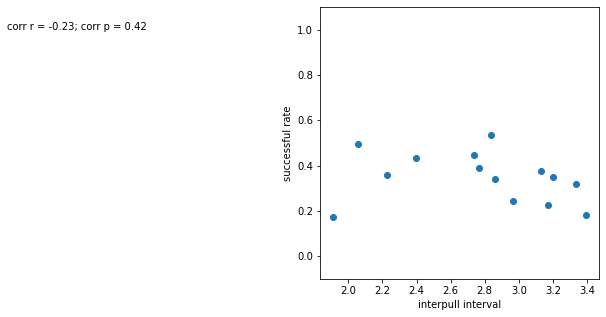

In [46]:
fig, axs = plt.subplots(1,1,figsize=(5, 5))

# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx = interpullintv_all_dates[ind]
yyy = succ_rate_all_dates[ind]
axs.plot(xxx,yyy,'o')
axs.set_xlabel('interpull interval')
axs.set_ylabel('successful rate')
# axs.set_xlim([-0.1,1.1])
axs.set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy)
axs.text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.05; corr p = 0.8')

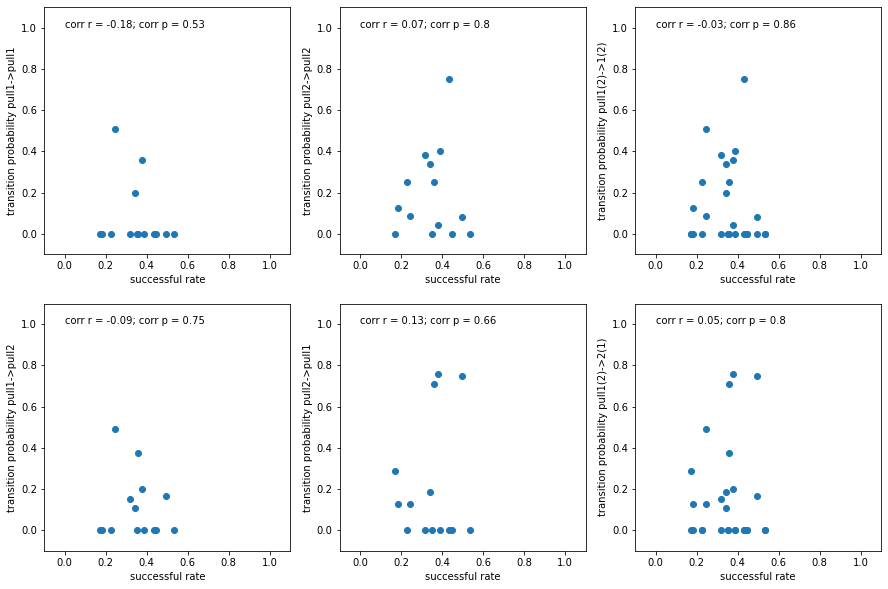

In [47]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)
#
xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull1(2)->2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - interpull interval

Text(0, 1, 'corr r = -0.3; corr p = 0.13')

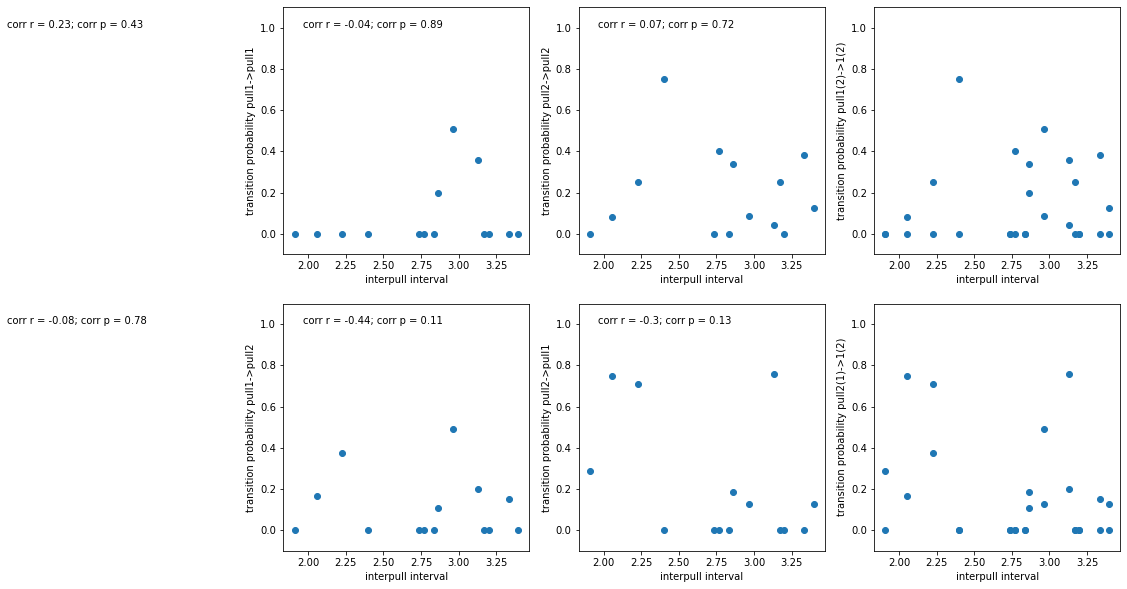

In [48]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx  = interpullintv_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('interpull interval')
axs[0,0].set_ylabel('transition probability '+y1label)
#axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('interpull interval')
axs[0,1].set_ylabel('transition probability '+y2label)
#axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('interpull interval')
axs[1,0].set_ylabel('transition probability '+y3label)
#axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('interpull interval')
axs[1,1].set_ylabel('transition probability '+y4label)
#axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('interpull interval')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
#axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('interpull interval')
axs[1,2].set_ylabel('transition probability pull2(1)->1(2)')
#axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.0; corr p = 0.99')

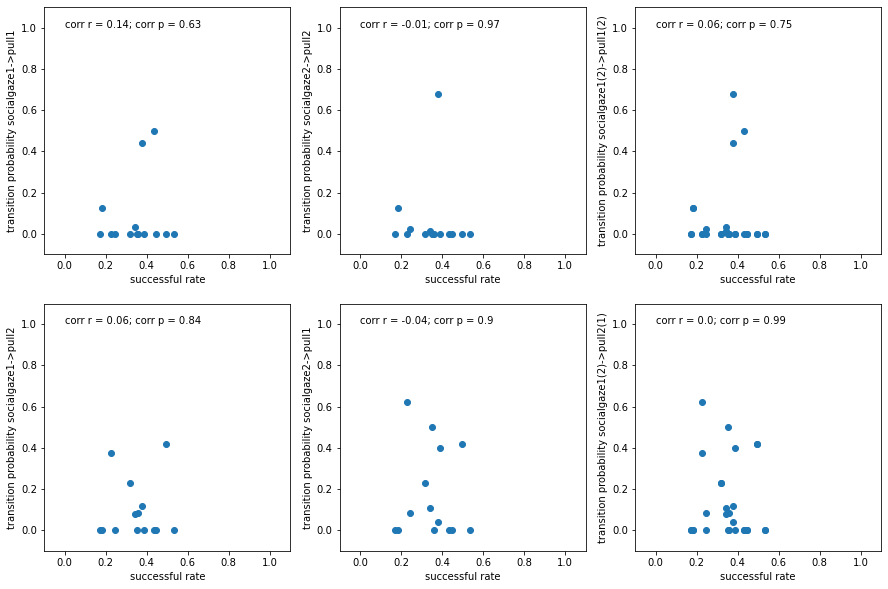

In [49]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,0]
y1label = "socialgaze1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,1]
y2label = "socialgaze2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,1]
y3label = "socialgaze1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,0]
y4label = "socialgaze2->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->pull1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability socialgaze1(2)->pull2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the pull -> gaze transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = -0.11; corr p = 0.58')

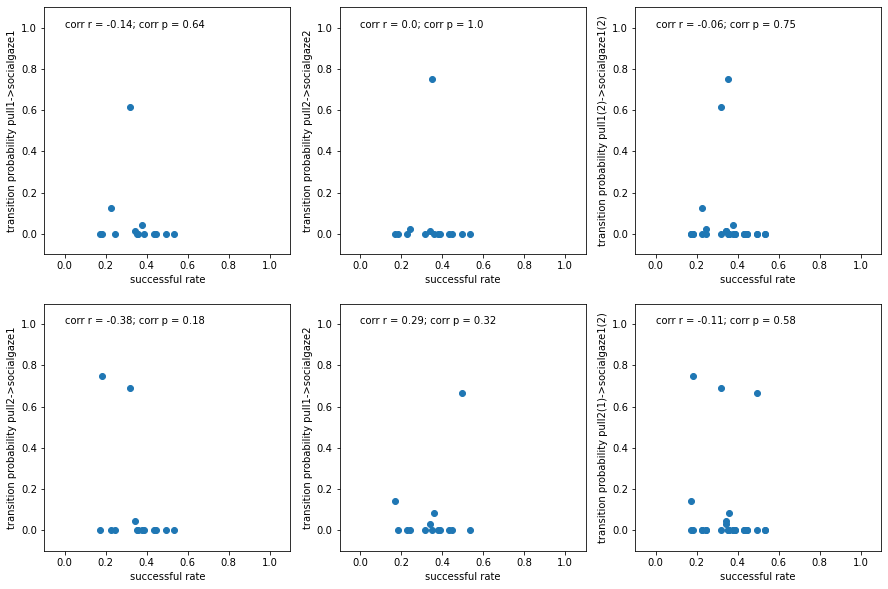

In [50]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,2]
y1label = "pull1->socialgaze1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,3]
y2label = "pull2->socialgaze2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],1,2]
y3label = "pull2->socialgaze1"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],0,3]
y4label = "pull1->socialgaze2"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->socialgaze1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull2(1)->socialgaze1(2)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze -> gaze transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = -0.01; corr p = 0.98')

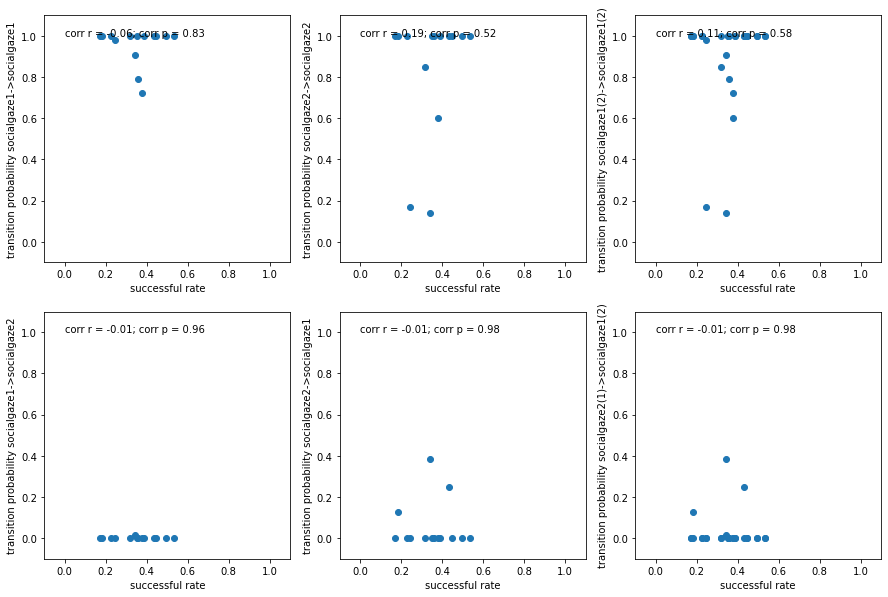

In [51]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,2]
y1label = "socialgaze1->socialgaze1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,3]
y2label = "socialgaze2->socialgaze2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,3]
y3label = "socialgaze1->socialgaze2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,2]
y4label = "socialgaze2->socialgaze1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->socialgaze1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability socialgaze2(1)->socialgaze1(2)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs gaze/pull ratio

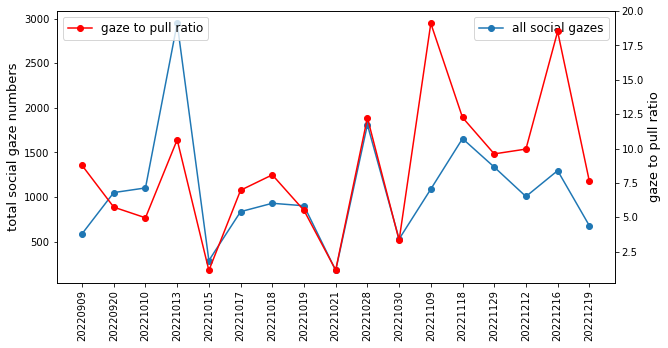

In [52]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(gaze_numbers,'o-',label = "all social gazes")

ax1.legend(fontsize=12)
ax1.set_ylabel("total social gaze numbers",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
ax2 = ax1.twinx()
ax2.plot(gaze_pull_ratios,'ro-',label = "gaze to pull ratio")
ax2.legend(fontsize=12)
ax2.set_ylabel("gaze to pull ratio",fontsize=13)
#
plt.show()


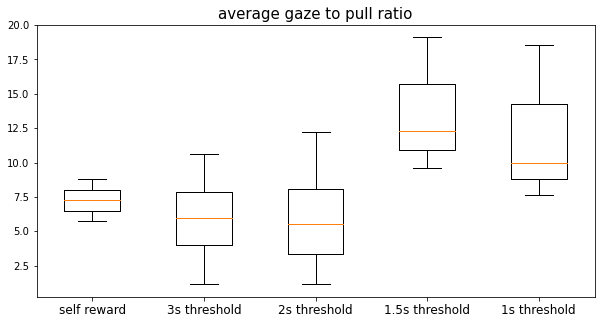

In [53]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze_numbers_groups = [np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==0)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==3)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==2)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==1.5)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average gaze to pull ratio',fontsize = 15);

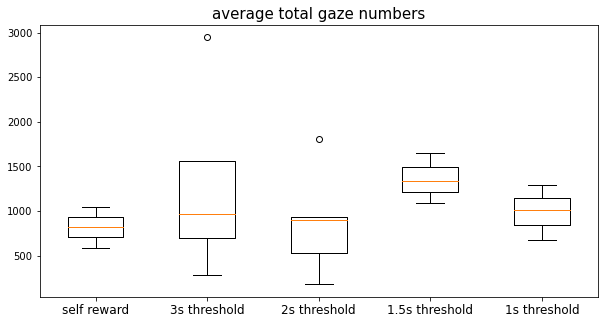

In [54]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze_numbers_groups = [np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==0)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==3)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==2)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==1.5)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average total gaze numbers',fontsize = 15);

Text(0, 1, 'corr r = 0.01; corr p = 0.94')

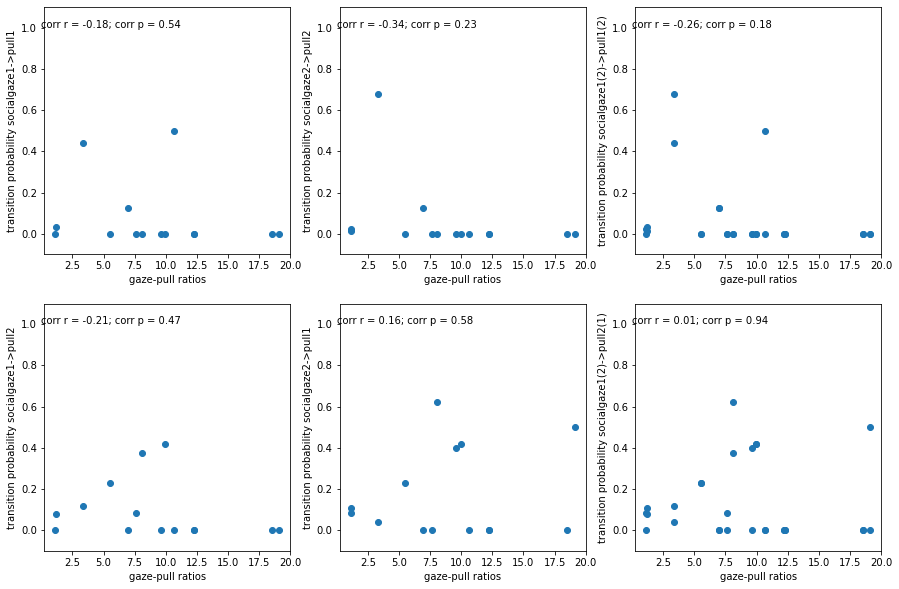

In [55]:
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)
# gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = gaze_pull_ratios[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,0]
y1label = "socialgaze1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,1]
y2label = "socialgaze2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,1]
y3label = "socialgaze1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,0]
y4label = "socialgaze2->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('gaze-pull ratios')
axs[0,0].set_ylabel('transition probability '+y1label)
# axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('gaze-pull ratios')
axs[0,1].set_ylabel('transition probability '+y2label)
# axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('gaze-pull ratios')
axs[1,0].set_ylabel('transition probability '+y3label)
# axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('gaze-pull ratios')
axs[1,1].set_ylabel('transition probability '+y4label)
# axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('gaze-pull ratios')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->pull1(2)')
# axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('gaze-pull ratios')
axs[1,2].set_ylabel('transition probability socialgaze1(2)->pull2(1)')
# axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))


